## Проект: аренды самокатов GoFast.
**В проекте используются данные о пользователях сервиса GoFast и информации о их поездках.** \
\
**Для начала мы ознакомимся с данными в случае ошибок исправим их, далее на основе этих дынных проведём некоторые вычисления с построением графиков, к примеру узнаем какое в среднем пользователи преодолевают расстояние за одну поездку, их примерный возраст, преодолённую дистанцию, итд. Также разделим пользователей на две категории с подпиской и без.** \
\
**На основе имеющихся данных проверим несколько гипотез, касающихся сравнения категорий пользователей**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
from scipy.stats import binom, norm, poisson
from math import factorial, sqrt

### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date']) # Задаём параметр переводящий даты в datetime по сотлбцу date.
subs = pd.read_csv('/datasets/subscriptions_go.csv')

#### Первый взляд на датасеты.

In [3]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<span style="color:purple"><b>Всё в порядке.</b></span>

In [4]:
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<span style="color:purple"><b>Столбец datetime исправлен во время загрузки df'a.</b></span>

In [5]:
subs.info()
subs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<span style="color:purple"><b>Порядок.</b></span>

#### Промежуточный вывод.
**На руках имеем 3 датасета с данными.** \
* **users содержит следующую информацию - ID пользователя, имя, возраст, наименование города, категорию подписки.** \
* **В rides - ID, дистанция, продолжительность поездки, и дату поездки.** \
* **В subs содержится информация о типе подписки, стоимости одной минуты, стартовой цены, стоимости подписки.** \

*В целом типы данных выглядят верными, единственное что была обнаруженна ошибка в типе данных времени, но исправление внесено на этапе загрузки.*


### Шаг 2. Предобработка данных

#### Изменение типов столбцов, добавление столбцов.

<AxesSubplot:>

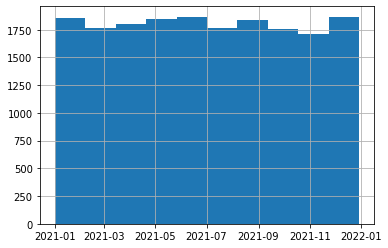

In [6]:
rides['date'].hist()

In [7]:
rides['month'] = rides['date'].dt.month # Создаём новый столбец с номерами месяца.

<span style="color:purple"><b>Период данных меньше года, потому можно для значений месяца взять только одно число без использования года.</b></span>

#### Пропущенные значения.

In [8]:
print(users.isna().sum())
print(rides.isna().sum())
print(subs.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


<span style="color:purple"><b>Пропущенных значений нет.</b></span>

#### Проверка на дубликаты.

In [9]:
print(users.duplicated().sum()) # Проверка на дубликаты и их вынос.
print(rides.duplicated().sum())
print(subs.duplicated().sum())

31
0
0


In [10]:
users = users.drop_duplicates()

<span style="color:purple"><b>Дубликаты обнаружены и удалены.</b></span>

#### Аномалии.

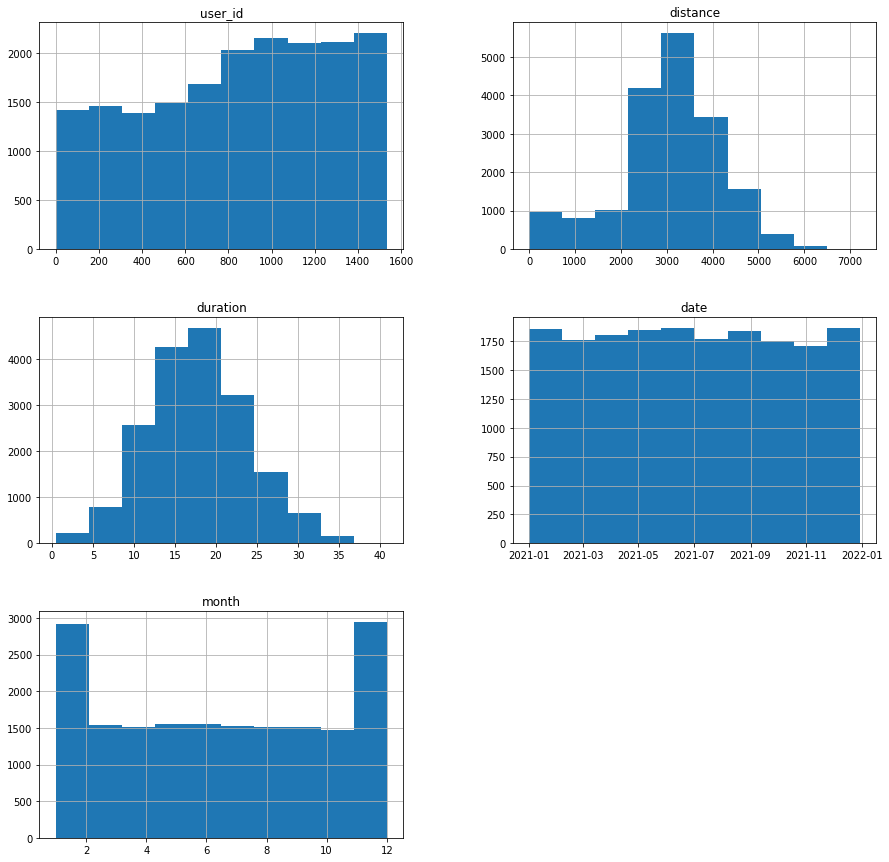

In [11]:
rides.hist(figsize=(15, 15))
print()

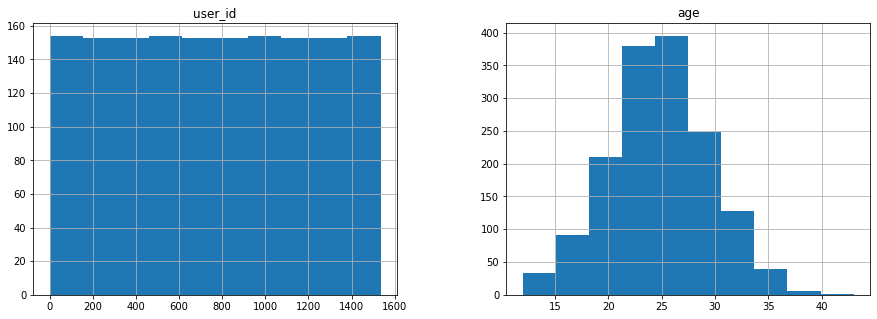

In [12]:
users.hist(figsize=(15, 5))
print()

<span style="color:purple"><b>Аномальные значения продоложительности поездки и дистанции, скорее всего связанные с неисправностью самоката.</b></span>

In [13]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [14]:
rides[rides['duration'] < 1].head(10)

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
6860,724,6225.520342,0.5,2021-12-16,12
6883,726,4452.491518,0.5,2021-03-01,3
7018,735,4406.954812,0.5,2021-04-13,4
7160,745,5286.167732,0.5,2021-08-17,8
7364,760,4881.391865,0.5,2021-08-29,8


In [15]:
rides[rides['duration'] < 1].count()

user_id     95
distance    95
duration    95
date        95
month       95
dtype: int64

In [16]:
rides = rides[rides['duration'] > 0.5]

In [17]:
rides[(rides['distance'] / rides['duration']) > 400]

,user_id,distance,duration,date,month
6648,709,4385.459636,10.770919,2021-12-04,12
7106,741,4746.964750,11.821306,2021-08-25,8
9099,894,5507.980168,13.015960,2021-11-30,11
11696,1078,4888.505444,11.777011,2021-09-01,9
11909,1095,4932.033033,12.204206,2021-05-20,5
12356,1128,4516.806367,11.033613,2021-10-06,10
12753,1157,4123.034244,10.246068,2021-12-19,12
12840,1163,4880.702286,11.761405,2021-06-15,6
13196,1190,4143.808108,10.287616,2021-03-19,3
13975,1243,5003.678510,12.352438,2021-05-15,5


In [18]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


#### Промежуточный вывод:
* **В предобратобке данных мы проверили период времени в датасете, так-как период меньше года для удобства используем только число месяца** 
* **Произвели проверку на пропущенные значение - их не оказалось.**
* **Проверка на дубликаты дала положительный результат в датасете users, дубликаты были удалены.**
* **С помощью гистограмм данные проверенны на выбросы или аномальные скачки, обнаружены аномалии в продолжительности поездки, время в 0.5 минут с разными дистанциями равными нескольким километрам. Удалены.**

### Исследовательский анализ данных

#### Частота встречаемости городов.

city
Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: user_id, dtype: int64


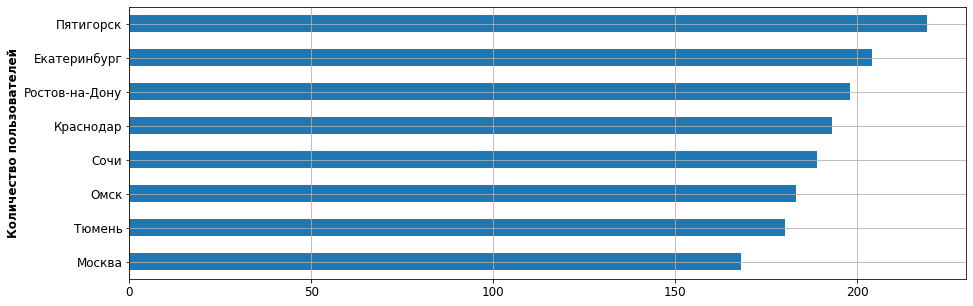

In [19]:
users_city_hist = users.groupby('city')['user_id'].count().sort_values()
uch = users_city_hist.plot(x='city', y='user_id', figsize=(15, 5), kind='barh',
                     xlabel='', grid=True, fontsize='12')
uch.set_ylabel('Количество пользователей', fontsize='12', fontweight='bold')
print(users_city_hist)

<span style="color:purple"><b>В общем 8 городов. Чаще встречается город - Пятигорск, реже всего Москва, разница между количеством пользователей из разных городов небольшая.</b></span>

#### Соотношение пользователей с подпиской и без подписки.

Соотношение пользователей с подпиской и без = 1.195


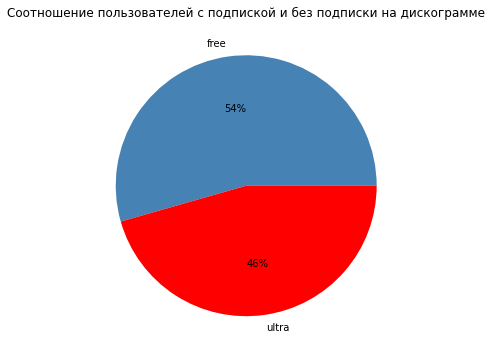

In [20]:
users_subs_pie = users.groupby('subscription_type')['user_id'].count()
users_subs_pie.plot(kind='pie', figsize=(6, 6), colors=['steelblue', 'red'], autopct='%1.0f%%', ylabel='',
                    title='Соотношение пользователей с подпиской и без подписки на дискограмме', legend=False)

print('Соотношение пользователей с подпиской и без =', round(users_subs_pie[0] / users_subs_pie[1], 3))

<span style="color:purple"><b>Людей без подписки чуть больше половины.</b></span>

#### Возраст пользователей.

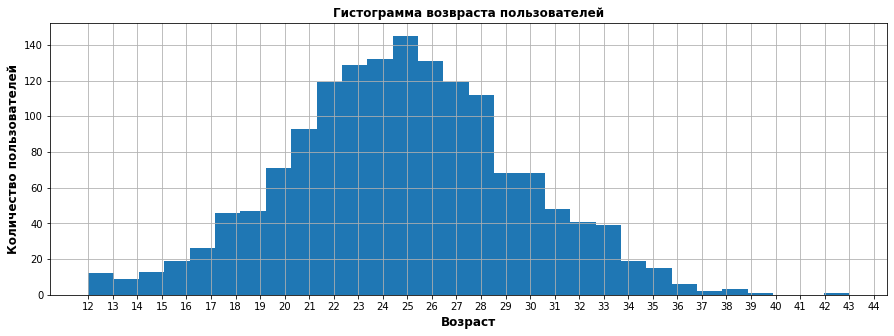

In [21]:
users_ages = users['age'].hist(figsize=(15, 5), bins=30)
users_ages.set_xticks(np.arange(12,45,1))
users_ages.set_xlabel('Возраст', fontsize='12', fontweight='bold')
users_ages.set_ylabel('Количество пользователей', fontsize='12', fontweight='bold')
users_ages.set_title('Гистограмма возвраста пользователей', fontsize='12', fontweight='bold')
print()

In [22]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

<span style="color:purple"><b>Промежуточные значения от первого до третьего квартиля состовляют от 22 до 28 лет.
    Средний возрат 24 года.</b></span>

#### Расстояние, которое пользователь преодолел за одну поездку.

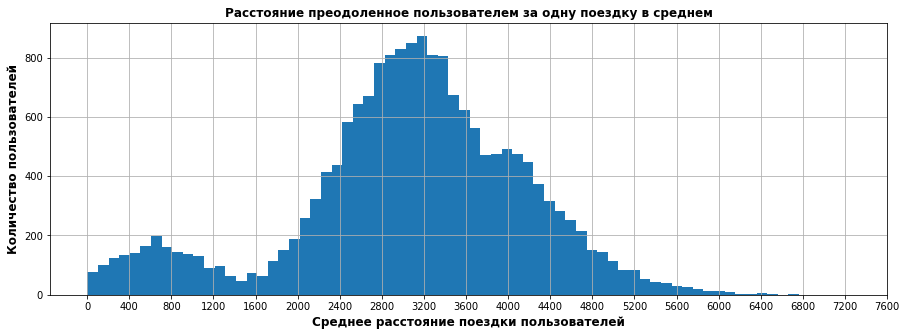

In [23]:
rides_dist = rides['distance']
rides_dist = rides_dist.hist(figsize=(15, 5), bins=70)
rides_dist.set_xlabel('Среднее расстояние поездки пользователей', fontsize='12', fontweight='bold')
rides_dist.set_ylabel('Количество пользователей', fontsize='12', fontweight='bold')
rides_dist.set_title('Расстояние преодоленное пользователем за одну поездку в среднем', fontsize='12', fontweight='bold')
rides_dist.set_xticks(np.arange(0,8000,400))
print()

In [24]:
rides['distance'].describe()

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64

<span style="color:purple"><b>От первого до третьего квартиля расстояние поездки состовляет от 2.5 до 3.8км</b></span>

#### Продолжительность поездок.

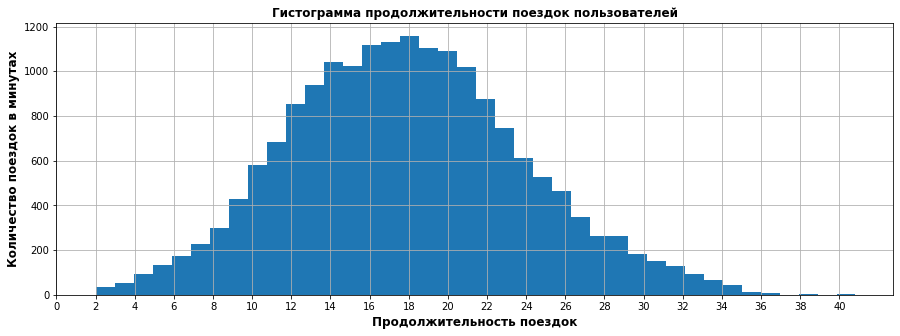

In [25]:
rides_dur = rides['duration'].hist(figsize=(15, 5), bins=40)
rides_dur.set_xlabel('Продолжительность поездок', fontsize='12', fontweight='bold')
rides_dur.set_ylabel('Количество поездок в минутах', fontsize='12', fontweight='bold')
rides_dur.set_xticks(np.arange(0,42,2))
rides_dur.set_title('Гистограмма продолжительности поездок пользователей', fontsize='12', fontweight='bold')
print()

In [26]:
rides['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

<span style="color:purple"><b>Продолжительность поездки от первого квартиля до третьего состовляет от 14 до 22 минут.</b></span>

### Объединение данных

#### Объеденение трёх таблиц в одну.

In [27]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [28]:
data = users.merge(rides, on='user_id', how='left')
print(data.info())
data = data.merge(subs, on='subscription_type', how='left')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             -------------

<span style="color:purple"><b>Производим мерж таблиц, в таблице rides имеем 17913 строк, после левостороннего мержа количество строк сохраняется.</b></span>

#### Создание отдельных таблиц-категорий пользователей с подпиской и без.

In [29]:
data_subs_on = data[data['subscription_type'] == 'ultra']
data_subs_off = data[data['subscription_type'] == 'free']

#### Расстояние и время, преодоленное для обоих категорий.

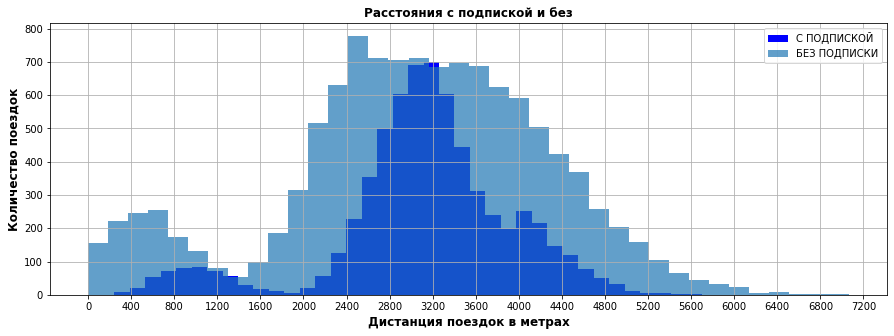

In [30]:
rides_dur2 = data_subs_on['distance'].hist(figsize=(15, 5), bins=38, color='blue', label='C ПОДПИСКОЙ')

rides_dur2 = data_subs_off['distance'].hist(figsize=(15, 5), bins=38, alpha=0.7, label='БЕЗ ПОДПИСКИ')
rides_dur2.set_xlabel('Дистанция поездок в метрах', fontsize='12', fontweight='bold')
rides_dur2.set_ylabel('Количество поездок', fontsize='12', fontweight='bold')
rides_dur2.set_xticks(np.arange(0,7600,400))
rides_dur2.set_title('Расстояния с подпиской и без', fontsize='12', fontweight='bold')

#rides_dur2 = data_subs_on['distance'].hist(figsize=(15, 5), bins=38, color='blue', legend=True, alpha=0.0)
# Пришлось сделать третью запись, так-как параметры legend и label не могут использоваться сразу вместе, 
# получается можно указать либо legend=True, либо я имею возможность указать наименование label, 
# но при этом legend дефолтно принимает значение False, третьего варианта не нашёл.


# есть вариант проще (ниже), строку с твоим кодом закомментировал, чтобы показать работоспособность
plt.legend()

print()

<span style="color:purple"><b>На основе двух графиков можно сделать вывод что пользователи с подпиской чаще ездят на одни и теже расстояния. \
Вероятно связано с тем что пользователи с подпиской чаще используют самокаты для того что-бы добраться до работы, или учёбы.</b></span>

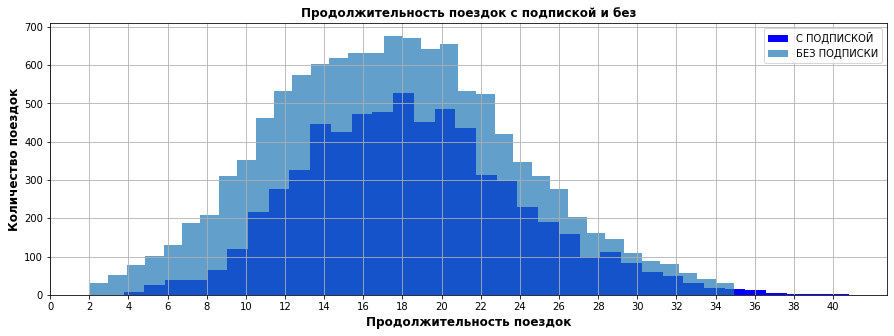

In [31]:
rides_dur = data_subs_on['duration'].hist(figsize=(15, 5), bins=35, color='blue', label='C ПОДПИСКОЙ')

rides_dur = data_subs_off['duration'].hist(figsize=(15, 5), bins=35, alpha=0.7, label='БЕЗ ПОДПИСКИ')
rides_dur.set_xlabel('Продолжительность поездок', fontsize='12', fontweight='bold')
rides_dur.set_ylabel('Количество поездок', fontsize='12', fontweight='bold')
rides_dur.set_title('Продолжительность поездок с подпиской и без', fontsize='12', fontweight='bold')
rides_dur.set_xticks(np.arange(0,42,2))

#rides_dur = data_subs_on['duration'].hist(figsize=(15, 5), bins=35, color='blue', legend=True, alpha=0.0)

plt.legend()
print()

<span style="color:purple"><b>Примерно одинаковое распределение продолжительности поездки, с учётом предидущего графика эти графики имеют подозрительно пропорциональный вид.</b></span>

### Подсчёт выручки

In [32]:
data_agr = data.loc[:, ['user_id', 'subscription_type', 'month']]
data_agr['sum_distance'] = data.groupby(['user_id', 'month'])['distance'].transform(lambda x: x.sum())
data_agr['sum_duration'] = data.groupby(['user_id', 'month'])['duration'].transform(lambda x: x.apply(np.ceil).sum())
data_agr['count'] = data.groupby(['user_id', 'month'])['user_id'].transform(lambda x: x.count())
# Получаем суммы, не забываем про своевременное округление вверх.
data_agr = data_agr.drop_duplicates().reset_index(drop=True)
# Тут появляются дубликаты.
data_agr = data_agr.merge(subs, on='subscription_type')
# Соеденяю таблицы для более простого кода рассчёта.

In [33]:
# код ревьюера
(data.groupby(['user_id', 'month', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'])
     .agg({'distance' : 'sum',
           'duration' : 'sum',
           'date' : 'count'})
     .reset_index()
)

,user_id,month,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date
0,1,1,ultra,6,0,199,7027.511294,41.416640,2
1,1,4,ultra,6,0,199,754.159807,6.232113,1
2,1,8,ultra,6,0,199,6723.470560,44.776802,2
3,1,10,ultra,6,0,199,5809.911100,31.578017,2
4,1,11,ultra,6,0,199,7003.499363,53.397424,3
...,...,...,...,...,...,...,...,...,...
11295,1534,6,free,8,50,0,3409.468534,24.812678,2
11296,1534,8,free,8,50,0,7622.453034,47.205960,2
11297,1534,9,free,8,50,0,4928.173852,22.560373,1
11298,1534,11,free,8,50,0,13350.015305,76.342174,4


In [34]:
data_agr.head(10)

,user_id,subscription_type,month,sum_distance,sum_duration,count,minute_price,start_ride_price,subscription_fee
0,1,ultra,1,7027.511294,42.0,2,6,0,199
1,1,ultra,4,754.159807,7.0,1,6,0,199
2,1,ultra,8,6723.470560,46.0,2,6,0,199
3,1,ultra,10,5809.911100,32.0,2,6,0,199
4,1,ultra,11,7003.499363,56.0,3,6,0,199
5,1,ultra,12,6751.629942,28.0,2,6,0,199
6,2,ultra,3,10187.723006,63.0,3,6,0,199
7,2,ultra,4,6164.381824,40.0,2,6,0,199
8,2,ultra,6,3255.338202,14.0,1,6,0,199
9,2,ultra,7,6780.722964,48.0,2,6,0,199


In [35]:
data_agr['profit'] = data_agr['sum_duration'] * data_agr['minute_price'] + \
data_agr['count'] * data_agr['start_ride_price'] + data_agr['subscription_fee']
# Рассчёт профита.

### Проверка гипотез

#### Тратят ли пользователи с подпиской больше времени на поездки?

<span style="color:purple"><b>Гипотеза h0 - обе категории пользователей тратят на поездки одно и тоже время. \
Гипотеза h1 - пользователи с подпиской тратят больше времени на поездки.</b></span>

In [36]:
alpha = 0.05
results = st.ttest_rel(data_subs_on['duration'], 
                       data_subs_off['duration'].sample(n = 6500), alternative='greater')

print('pvalue', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Опровергнуть нулевую гипотезу нельзя")

pvalue 1.0424793873135756e-19
Отвергаем нулевую гипотезу в пользу альтернативной


In [37]:
print('Средняя продолжительность поездки пользователей с подпиской =', data_subs_on['duration'].mean())
print('Средняя продолжительность поездки пользователей без подписки =', data_subs_off['duration'].mean())

Средняя продолжительность поездки пользователей с подпиской = 18.54198516280583
Средняя продолжительность поездки пользователей без подписки = 17.530771268800226


<span style="color:purple"><b>P-значение, основаного на результате правостороннего t-теста парных выборок меньше установленного уровня значимости alpha равному 0.05%, что отвергает гипотезу h0. Пользователи с подпиской тратят больше времени на поездку.</b></span>

#### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

<span style="color:purple"><b>Гипотеза h0 - Пользователи с подпиской проезжают не более 3130 метров за одну поездку. \
Гипотеза h1 - Пользователи с подпиской проезжают за одну поездку более 3130 метров.</b></span>

In [38]:
dist = data_subs_on['distance'].astype('int')
alpha = 0.05
value = 3130
results = st.ttest_1samp(dist, value, alternative='greater')
print('pvalue', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Опровергнуть нулевую гипотезу нельзя")

pvalue 0.9264356652998772
Опровергнуть нулевую гипотезу нельзя


In [39]:
data_subs_on['distance'].mean()

3115.4453880370247

In [40]:
data_subs_on.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,6.422308,6.0,0.0,199.0
std,201.099339,4.757208,836.895330,5.572048,3.414616,0.0,0.0,0.0
min,1.000000,12.000000,244.210438,3.760353,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.444017,14.524654,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3148.637229,18.178153,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3560.574425,21.884129,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5699.769662,40.823963,12.000000,6.0,0.0,199.0


<span style="color:purple"><b>P-значение полученное на основе правостороннего t-теста превышает уровень значимости alpha равный 0.05 не подтверждает гипотезу h1. Преодоленное расстояние за одну поездку не превышает 3130 метров.</b></span>

#### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

<span style="color:purple"><b>Гипотеза h0 - Помесячная выручка обоих категорий пользователей примерно равна. \
Гипотеза h1 - Помесячная выручка от пользователей с подпиской выше.</b></span>

In [41]:
alpha = 0.05

results = st.ttest_rel(data_agr[data_agr['subscription_type'] == 'ultra']['profit'], 
                       data_agr[data_agr['subscription_type'] == 'free']['profit'].sample(n = 4533), alternative='greater')

print('p-value', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Опровергнуть нулевую гипотезу нельзя")

p-value 3.4599607615671093e-31
Отвергаем нулевую гипотезу в пользу альтернативной


In [42]:
print('Средняя выручка пользователей с подпиской =', data_agr[data_agr['subscription_type'] == 'ultra']['profit'].mean())
print('Средняя выручка пользователей без подписки =', data_agr[data_agr['subscription_type'] == 'free']['profit'].mean())

print()

Средняя выручка пользователей с подпиской = 362.7921906022502
Средняя выручка пользователей без подписки = 329.3326437121324



<span style="color:purple"><b>P-значение, основаного на результате правостороннего t-теста парных выборок меньше установленного уровня значимости alpha равному 0.05%, что отвергает гипотезу h0. Помесячная выручка от пользователей с подпиской выше.</b></span>

In [43]:
# код ревьюера
print('p-value', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("Опровергнуть нулевую гипотезу нельзя")

print('Средняя длительность поездки Ultra', data_agr[data_agr['subscription_type'] == 'ultra']['profit'].mean())
print('Средняя длительность поездки Free', data_agr[data_agr['subscription_type'] == 'free']['profit'].mean())

p-value 3.4599607615671093e-31
Отвергаем нулевую гипотезу в пользу альтернативной
Средняя длительность поездки Ultra 362.7921906022502
Средняя длительность поездки Free 329.3326437121324


#### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

<span style="color:purple"><b>Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применим метод о равенстве среднего значения генеральной совокупности до и после изменения. Метод scipy.stats.ttest_rel()</b></span>

### Распределения

#### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

In [44]:
for i in range(1100, 1200):
    mu = i * 0.1             # Математическое ожидание биноминального распределения.
    sigma = (i*0.1*0.9)**0.5 # Стандартное отклонение биноминального распределения.
    distr = st.norm(mu, sigma)
    x = 100 # Количество подписок.
    result = distr.cdf(x)
    if i == 1161:
        print(result)
    if result < 0.05:
        print('вероятность не выполнить план: ', round(result,5)*100,'%', sep='')
        print('количество промокодов:', i)
        break
    

0.05762489347496267
вероятность не выполнить план: 4.971%
количество промокодов: 1169


<span style="color:purple"><b>Отделу маркетинга надо разослать минимум 1169 промокодов что-бы вероятность не выполнения плана была не более 5%</b></span>

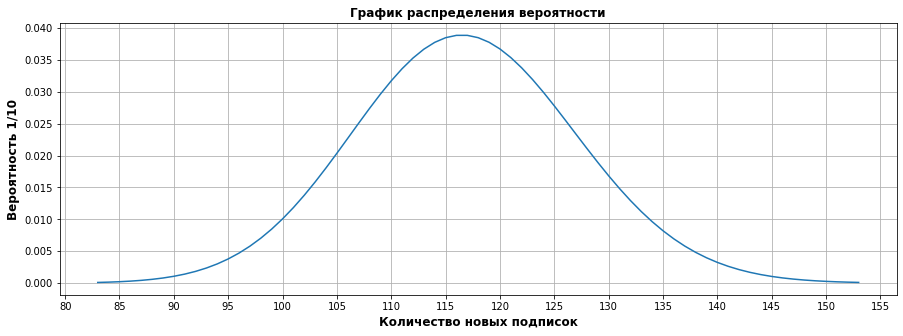

In [45]:
n = 1169 # количество попыток
p = 0.1 # вероятность успеха
distr = []
for k in range(0, n + 1):
    choose = factorial(n) // (factorial(k) * factorial(n - k))
    prob = choose // (10**k) * (1 - p)**(n - k) 
    distr.append(prob)
x = [i for i in range(0, n + 1)]
d = {'col1': x, 'col2': distr}
df = pd.DataFrame(data=d)
df = df[df['col2'] > 0.0001]
f = df.plot(x='col1', y='col2', figsize=(15, 5), grid=True, legend=False)
f.set_xticks(np.arange(80,160,5))
f.set_xlabel('Количество новых подписок', fontsize='12', fontweight='bold')
f.set_ylabel('Вероятность 1/10', fontsize='12', fontweight='bold')
f.set_title('График распределения вероятности', fontsize='12', fontweight='bold')
print()

<span style="color:purple"><b>График распределения вероятности при выдаче 1169 промокодов. \
     Вероятность не выполнить план: 4.971%</b></span>

In [46]:
for i in range(1100, 1200):
    sigma = 0.1
    x = 100 # Количество подписок.
    result = binom.cdf(x - 1, i, sigma)
    if result < 0.05:
        print('вероятность не выполнить план: ', round(result,5)*100,'%', sep='')
        print('количество промокодов:', i)
        break

вероятность не выполнить план: 4.976%
количество промокодов: 1161


In [47]:
# Код ревьюера

target_clients = 100  # Целевое количество клиентов для продления подписки
p_renewal = 0.1       # Вероятность продления подписки

# Подбор значения параметра n
n = 1
while binom.cdf(target_clients - 1, n, p_renewal) > 0.05:
    n += 1

# Вывод 
print(f"Минимальное количество промокодов: {n}")
print(f"Вероятность не выполнить план при таком количестве промокодов: {binom.cdf(target_clients - 1, n, p_renewal):.3%}")

Минимальное количество промокодов: 1161
Вероятность не выполнить план при таком количестве промокодов: 4.976%


#### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [48]:
# задаём параметры биномиального распределения

n = 1000000 # количество попыток
p = 0.4 # вероятность успеха

mu = n * p # Мат. ожидание.

sigma = (n * p * (1 - p))**0.5 # Стандартное отклонение.

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность левого хвоста от 399.5 тысяч
result = distr.cdf(399500)
print(round(result, 4))

0.1537


<span style="color:purple"><b>Вероятность того что уведомление откроют не более 399.5 тысяч пользователей 15.3%</b></span>

Условие выполняется



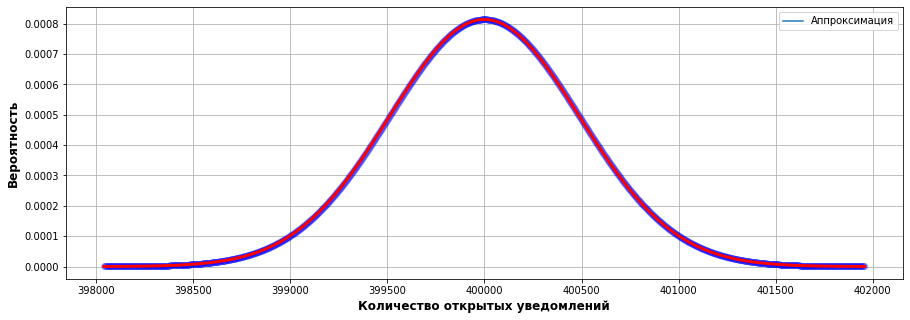

In [49]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []                              # Функция создающая список для нормального распределения.
    for i in range(num):
        result.append(start + step * i)
    return result

n = 1000000            # Наши значения
p = 0.4

left = int(n * p - 4 * sqrt(n * p * (1 - p)))          # Границы интервала относительно наших значений.
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(max(0, left), right))                   # Интервал - список.
y = binom.pmf(x, n, p)

d = {'col1': x, 'Аппроксимация': y}
df = pd.DataFrame(data=d)
f = df.plot(x='col1', y='Аппроксимация', figsize=(15, 5), grid=True, legend=True) # Тут почему-то нельзя указывать параметры линии.

f.plot(x, y, 'bo', alpha=0.05, label='Аппроксимация') # В общем только через одно место получается задавать параметры.
                                                      # И то не всё работает.
f.set_xlabel('Количество открытых уведомлений', fontsize='12', fontweight='bold')
f.set_ylabel('Вероятность', fontsize='12', fontweight='bold')

mu = n * p
sigma = sqrt(n * p * (1 - p))
 
x = linspace(left, right, 100)       # График нормального распределения.
y = norm.pdf(x, mu, sigma)
f.plot(x, y, 'r-', lw=3, label='asdf') # Я не понимаю почему одни и теже параметры то работают то нет, то их оказывается вообще
                                       # нельзя указывать, хотя тут же в другом графике указывал и всё можно было.

if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):  # Проверка на верность выполнения аппроксимации
    print('Условие выполняется')
else:
    print('Условие не выполняется')

print()

<span style="color:purple"><b>Аппроксимация проходит по нормальному распределению.</b></span>

## Общий вывод:

### Предобработка данных

* *Тип данных дат переведены в datetime64[ns], добавлен столбец с номером месяца*
* *Были обнаружены и удалены дубликаты в df users_go.*
* *Обнаружены и удалены аномальные значения в датасете rides_go, в столбцах duration и distance.

### Исследовательский анализ данных

* *В общем 8 городов. Чаще встречается город Пятигорск, реже всего Москва.*
* *Соотношение пользователей с подпиской и без = 1.195, 46% и 54% соответственно.*
* *Основная масса пользователей в возрасте от 22 до 28 лет. Средний возраст пользователей 24 года.*
* *Основная масса пользователей за одну поездку проезжает от 2.5 до 3.8км*
* *В основном продолжительность поездки состоявляет от 14 до 22 минут*
* *Пользователи с подпиской чаще ездят на одни и теже расстояния.*
* *У пользователей с подпиской и без примерно одинаковое распределение продолжительности поездок*

### Проверка гипотез

#### Тратят ли пользователи с подпиской больше времени на поездки?

* *Гипотеза проверялась правосторонним равенством среднего значения генеральной совокупности и показала что пользователи с подпиской тратят больше времени на поездки*

#### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

* *Гипотеза проверялась равенством среднего генеральной совокупности числу и показало что расстояние за одну поездку не привышает 3130 метров*

#### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

* *Гипотеза проверялась правосторонним равенством среднего значения генеральной совокупности до и после изменения и показала что от пользователей с подпиской по месяцам выше чем выручка от пользоваталей без подписки.*

### Распределения

#### Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

* *Функция нормального распределения на основе предидущих данных показала что при рассылке 1161 промокодов вероятность того что будет оформлено менее 100 подписок равна менее 5%*

#### Отдел планирует разослать 1 млн уведомлений. Вероятность что уведомление откроют не более 399,5 тыс. пользователей.

* *Функция нормального распределения показала что при рассылке 1млн пуш уведомлений вероятность того что его откроют не более 399.5 тыс. пользователей равна 15.3%*